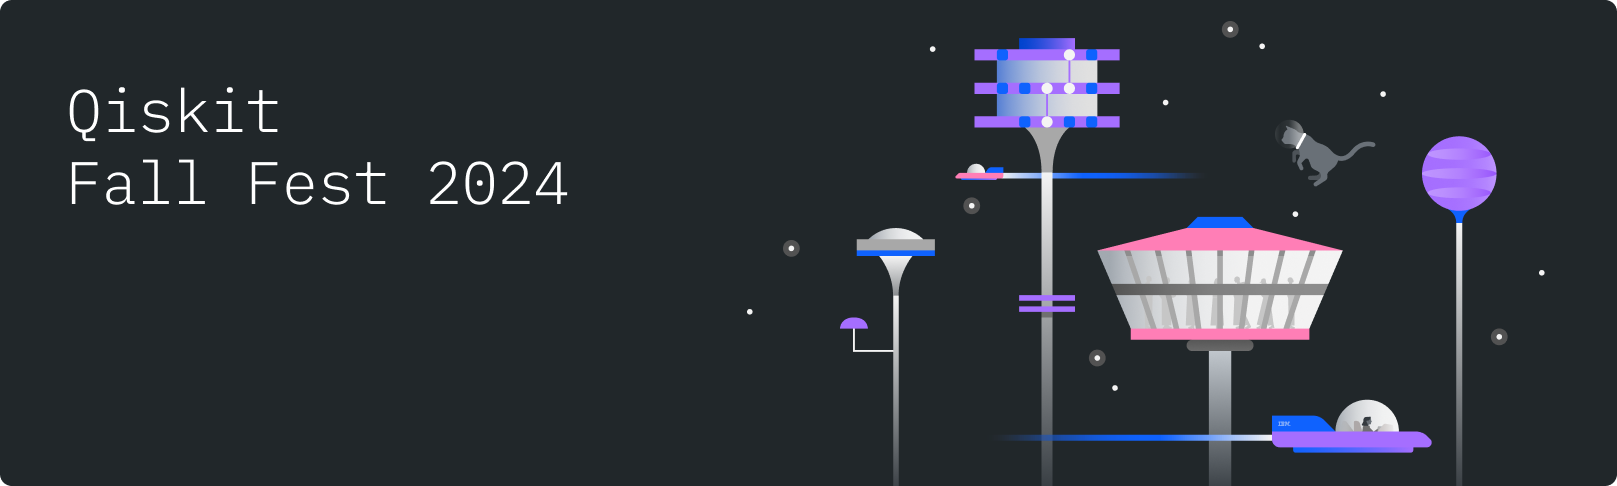

# Graded Notebook 2: Qiskit Runtime Lab

*   Difficulty: 3/5
*   Estimated Time: 60 minutes

これは Qiskit Fall Fest for Utokyo 2024 の Day1 で使うコードです👩‍💻

（各ノートブックには、特定の問題を解決するために必要なドキュメント、チュートリアル、その他の有用なリソースへのリンクが含まれています。これらのリソースの多くは、IBMの新しい量子教育プラットフォーム[IBM Quantum Learning](https://learning.quantum.ibm.com/)でも見つけることができます。）


<!-- Hi there and welcome to the **Qiskit Fall Fest**!

Whether you're a total beginner or a PhD candidate in quantum physics, there is something here for you. Thanks for joining us.  😀

As part of the Qiskit Fall Fest, IBM Quantum has created a series of notebooks for you to work through, which include coding challenges and Qiskit tutorials.

The Qiskit Fall Fest is a massive event, featuring thousands of students worldwide who are all learning about quantum computing and Qiskit. Just by being here, you're helping to make history. Your participation is helping to shape what the future of the industry will look like. Congratulations and welcome!

---

Each of these notebooks builds upon the previous learning. This first one is meant for anyone to complete, even beginners, but later notebooks are more difficult. Most participants will need to do some outside research or use a bit of trial-and-error to finish the code challenges presented in the more advanced notebooks. Don't give up! We know you can do it.

In each notebook, you will find links to documentation, tutorials, and other helpful resources you might need to solve that particular problem. You can also find most of these resources on IBM's new home for quantum education: [IBM Quantum Learning](https://learning.quantum.ibm.com/). -->

# 目次
- [Introduction](#intro)
- [Part I: Qiskit states, the new and the old](#pt1)
  - [Exercise 1: Create and draw a singlet Bell state circuit](#exercise1)
  - [Exercise 2: Use Sampler.run](#exercise2)
  - [Exercise 3: Create and draw a W-state circuit](#exercise3)   
- [Part II: VQE with Qiskit 1.0](#pt2)
  - [Exercise 4: Create a parameterized circuit to serve as the ansatz](#exercise4)    
  - [Exercise 5: Transpile to ISA circuits](#exercise5)
  - [Exercise 6: Defining the cost function](#exercise6)
  - [Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode and Sessions, a first look](#exercise7)


## セットアップ

まずは、必要なインストールとインポートをすべて済ませましょう。

ローカル環境で実行している場合、以前のノートブックでこれらをすでにインストールしているかもしれません。一方、クラウド環境で実行している場合は、各ノートブックごとに再インストールが必要になることがあります。


<!-- ## Setup

Let's begin by getting all the necessary installs and imports out of the way.

If you are running things locally, you may already have these installed from a previous notebook. If you're running in the cloud, you may need to re-install for each notebook. -->

In [1]:
# 必要なパッケージをインストール
requirements = [
    "qiskit[visualization]",
    "qiskit_aer",
    "qiskit_ibm_runtime",
    "qiskit-transpiler-service",
    "matplotlib",
    "pylatexenc",
    "git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
]
for x in requirements:
    !pip install $x > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-req-build-3hhxbv5e


In [2]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# Setup the grader
from qc_grader.challenges.fall_fest24 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6,
    grade_lab2_ex7,
)

import os
from google.colab import userdata

os.environ['QXToken'] = userdata.get('ibmToken')

## Introduction <a name="intro"></a>

このノートブックは、Qiskit 1.xバージョンのプリミティブに関する穏やかな入門編です。このノートブックでは、Qiskit RuntimeなどのIBM Quantumの最新のイノベーションを活用し、以下のトピックやスキルについて理解を深めることができます：

- Qiskitを使用して量子状態をセットアップする方法  
- Qiskit RuntimeのSamplerおよびEstimatorプリミティブ、そしてRuntimeの活用  
- 量子シミュレーターおよびIBM QuantumコンピューターでRuntimeを使用して回路を実行する方法  


<!-- This notebook is a gentle introduction to primitives of Qiskit 1.x version. This notebook leverages some the latest innovations from IBM Quantum, such as Qiskit Runtime, and will help you get up to speed on the following topics and skills:

- How to set up quantum states using Qiskit
- Leveraging Qiskit Runtime Sampler and Estimator primitives, and Runtime
- Executing circuits in quantum simulators as well as on IBM Quantum computers by using Runtime -->

# Part I: Qiskit states、the new and the old with Sampler <a name="pt1"></a>

***「人生はチョコレートの箱のようなもの」***

さあ、PythonとQiskitのコードに触れる時が来ました。今回の課題は、受け入れるかどうかはあなた次第ですが、バニラ（'01'）とラズベリー（'10'）フレーバーのチョコレートキャンディを2つ含む箱から1つをサンプリングするプログラムを開発することです。この課題では、'ベル状態'を使用して'01'と'10'を同じ確率で取得できる量子回路を構築することを目指します。

ベル状態には4つの異なる種類があります。それぞれについては、[量子の基本](https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems#bell-states)で学ぶことができます。



<!-- # Part I: Qiskit states, the new and the old with Sampler <a name="pt1"></a>

***Subtitle: “Life is like a box of chocolates”***

Now it time to get your hands dirty with Python and Qiskit code. Your assignment, should you choose to accept it, will be to develop a program that samples one piece from a box that contains two chocolate candies - vanilla ('01') and raspberry ('10') flavors. Your mission is build a quantum circuit that has a same probability of getting '01' and '10' by using a 'bell state'.

There exist 4 different Bell states. You can learn about each from the [Basics of Quantum Information page](https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems#bell-states) -->


<a id="exercise1"></a>
<a name="exercise1"></a>
<div class="alert alert-block alert-success">
    
### 演習 1: 単一ベル状態回路（a singlet Bell state circuit）の作成と描画
    
ベル回路は、ベル状態またはEPR対を生成する特定の回路であり、これはエンタングルされ正規化された基底ベクトルの一形態です。つまり、エンタングル状態を生成するために使用される回路であり、量子計算の重要な要素です。

**あなたのタスク:** $| \psi ^- \rangle$ ベル状態を生成する回路を構築してください。
    
</div>



<!-- <a id="exercise1"></a>
<a name="exercise1"></a>
<div class="alert alert-block alert-success">
    
### Exercise 1: Create and draw a singlet Bell state circuit
    
Bell circuits are specific circuits which generate Bell states, or EPR pairs, a form of entangled and normalized basis vectors. In other words, they are the circuits we use to generate entangled states, a key ingredient in quantum computations.

**Your Task:** please build a circuit that generates the $| \psi ^- \rangle$ Bell state.
    
</div> -->

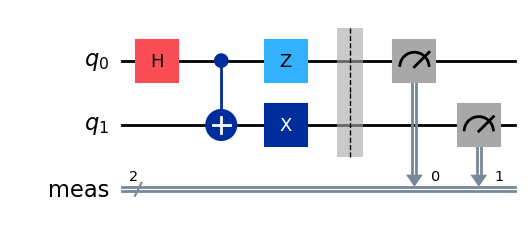

In [3]:
# Build a circuit to form a psi-minus Bell state
# Apply gates to the provided QuantumCircuit, qc

qc = QuantumCircuit(2)

### Write your code below here ###
qc.h(0)
qc.cx(0, 1)
qc.z(0)
qc.x(1)

### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

<div class="alert alert-block alert-warning">

**ヒント:** $| \psi ^- \rangle$ ベル状態では、1つのZゲートと1つのXゲートを使用します。これらはどちらもCNOTの後に適用されます。

</div>


<!-- <div class="alert alert-block alert-warning">

**Hint:** The $| \psi ^- \rangle$ Bell state uses a single Z gate, and a single X gate, both of which occur after the CNOT.

</div> -->

In [4]:
# Submit your answer using following code

grade_lab2_ex1(qc) # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


この回路が生成するエンタングル状態を観測するために、回路を複数回実行し、最終的な量子ビットの測定結果の統計を収集します。それが次の演習の目標です。


<!-- To observe the resulting entangled state that this circuit produces, we'll run our circuit a number of times and collect statistics on the final qubit measurements. That is the goal of the next exercise. -->

<a id="exercise2"></a>
<a name="exercise2"></a>
<div class="alert alert-block alert-success">
    
### 演習 2: Sampler.runを使用する
    
[Qiskit Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler)プリミティブ（[プリミティブに関する詳細はこちら](https://docs.quantum.ibm.com/run/primitives-get-started)）は、指定された出力タイプに応じたサンプル結果を返します。これにより、量子回路を実行して量子状態の確率分布を提供することで、量子状態を効率的にサンプリングすることができます。

**あなたのタスク:** Qiskit StatevectorSamplerを使用して、回路から得られるカウントを取得してください。
    
</div>


<!-- <a id="exercise2"></a>
<a name="exercise2"></a>
<div class="alert alert-block alert-success">
    
### Exercise 2: Use Sampler.run
    
The [Qiskit Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler) primitive ([more info on Primitives here](https://docs.quantum.ibm.com/run/primitives-get-started)) returns the sampled result according to the specified output type. It allows us to efficiently sample quantum states by executing quantum circuits and providing probability distributions of the quantum states.

**Your Task:** use the Qiskit StatevectorSampler to obtain the counts resulting from our circuit.
    
</div> -->

In [5]:
qc.measure_all()

### Write your code below here ###


sampler = StatevectorSampler()
pub = (qc,)
job_sampler = sampler.run([pub], shots=256)


### Don't change any code past this line ###

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01': 124, '10': 132}


In [6]:
# Submit your answer using following code

grade_lab2_ex2(job_sampler) # Expected result type: PrimitiveJob

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


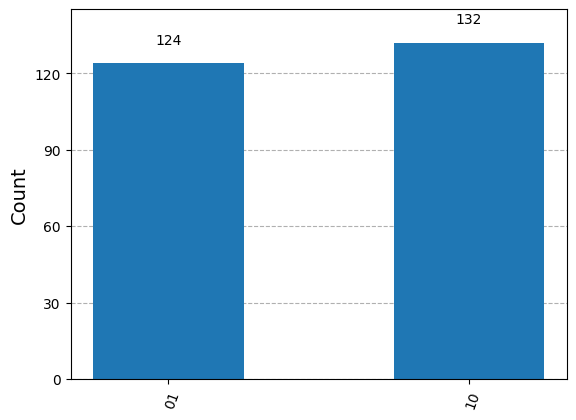

In [7]:
plot_histogram(counts_sampler)

ヒストグラムは、量子ビットが`01`状態または`10`状態で見つかる確率がほぼ均等であることを示しており、エンタングルメントが期待通りに行われたことを示唆しています。


<!-- The histogram shows an approximately even probability of finding our qubits in the `01` and the `10` states, suggesting that entanglement was performed as expected. -->

<a id="exercise3"></a>
<a name="exercise3"></a>
<div class="alert alert-block alert-success">
    
### 演習 3: W状態回路の作成と描画

次に、3つのチョコレートキャンディ（バニラ（`001`）、ラズベリー（`010`）、ストロベリー（`100`））を含む箱から1つのキャンディをサンプリングするプログラムを開発します。あなたのミッションは、これらのキャンディを均等な確率で返す回路を構築することです。このために、**W状態回路**を使用します。

ベル状態回路がベル状態を生成するのと同様に、W-state回路は[W-state](https://en.wikipedia.org/wiki/W_state)を生成します。ベル状態は2つの量子ビットをエンタングルさせますが、W状態は3つの量子ビットをエンタングルさせます。
W状態を構築するために、以下の6つの簡単なステップに従います：

1.  3量子ビット回路を初期化する
2.  量子ビットにRy回転を行う（この操作の詳細は提供されます）
3.  制御量子ビット0で制御ハダマードゲートを量子ビット1に適用する
4.  制御量子ビット1、ターゲット量子ビット2でCNOTゲートを追加する
5.  制御量子ビット0、ターゲット量子ビット1でCNOTゲートを追加する
6.  量子ビット0にXゲートを追加する

**あなたのタスク:** ステップに従って W-state 回路を構築してください
    
</div>


<!-- <a id="exercise3"></a>
<a name="exercise3"></a>
<div class="alert alert-block alert-success">
    
### Exercise 3: Create and draw a W-state circuit

Next, we will develop a program samples one piece of candy from a box that contains three chocolate candies - Vanilla (`001`), Raspberry (`010`) and Strawberry (`100`). Your mission is build a circuit that has a equal probability of returning those chocolates. For this, we will use a **W-state circuit**.

Similarly to Bell states circuit producing Bell states, W-state circuits produce [W states](https://en.wikipedia.org/wiki/W_state). Although Bell states entangle two qubits, W-states entangle three qubits.
To build our W-state, we will follow 6 simple steps:

1.  Initialize our 3 qubit circuit
2.  Perform an Ry rotation on our qubit. The specifics of this operation are provided.
3.  Perform a controlled hadamard gate on qubit 1, with control qubit 0
4.  Add a CNOT gate with control qubit 1 and target qubit 2
5.  Add a CNOT gate with control qubit 0 and target qubit 1
6.  Add a X gate on qubit 0

**Your Task:** Follow the steps to build the W-state circuit
    
</div> -->

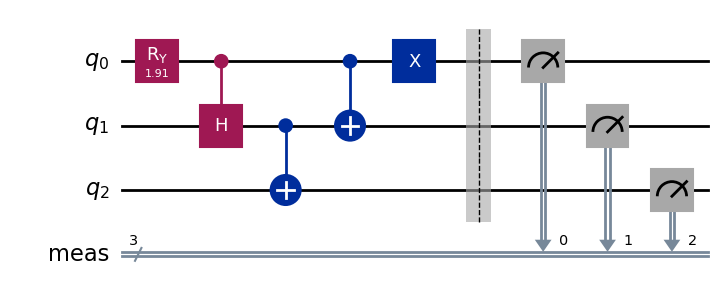

In [8]:
# Step 1
qc = QuantumCircuit(3)

# Step 2 (provided)
qc.ry(1.91063324, 0)

# Add steps 3-6 below
qc.ch(0, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.x(0)

### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

In [9]:
# Submit your answer using following code

grade_lab2_ex3(qc) # Expected result type: # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


もう一度、結果を視覚化してみましょう：


<!-- Once again, let's visualize our results: -->

In [10]:
sampler = StatevectorSampler()
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'010': 3305, '001': 3414, '100': 3281}


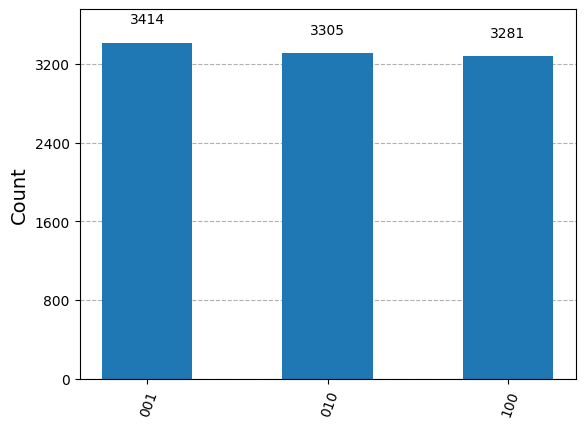

In [11]:
plot_histogram(counts_sampler)

測定結果の合計カウントが、3つの状態においてほぼ同じサイズの3つのビンに分布していることが確認できます。これは、W状態の成功した生成に必要な3つの期待される状態です。素晴らしい仕事です！

基本的な回路を理解したところで、これからはQiskit 1.0を使ってより複雑なコードの導入と開発を始めていきます。


<!-- We observe our total counts distributed in three similarly sized bins in three states, which are the three desired states for the successful creation of a W-state. Good work!

Now that we have basic circuits down, we'll start introducing and developing more complex codes with Qiskit 1.0. -->

# Part II: VQE with Qiskit 1.0

<a name="pt2"></a>

***サブタイトル: 「何が出てくるかはお楽しみ」***

チョコレートキャンディの箱から1つを選ぶとき、その選択はしばしば期待に応えるものです。しかし、キャンディをかじった後に、中身が自分の好みではないと気づくこともあります。この演習では、Qiskit Runtimeと変分量子固有値ソルバー（VQE）を活用して、期待に応えるキャンディの箱を組み立てます。Qiskit Runtime Estimatorを使用して箱の中のキャンディの組み合わせに対する期待値を計算し、Qiskit Runtimeセッションを利用してVQEアルゴリズムを実行し、最高の期待値を見つけます。

この課題の核心では、Qiskit Runtimeと変分量子固有値ソルバー（VQE）を活用します。Qiskit Runtime Estimatorを使って量子ビットの組み合わせに対する期待値を計算し、Qiskit Runtimeセッションを利用してVQEアルゴリズムを実行します。この課題は、実験物理学者でIBM Quantumの研究者であるNick Bronnが作成した[Qiskit Runtimeの動画](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM)の[episode 05 primitive と Session](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu)のコードに基づいており、最新のQiskit 1.0バージョンを使用して実装されています。


<!-- ***Subtitle: “You never know what you're gonna get”***


When selecting a piece of chocolate candy from a box, the piece often meets our expectations. Sometimes after biting into the candy however, we find that the filling is not our favorite. This exercise leverages Qiskit Runtime and a Variational Quantum Eigensolver (VQE) to assemble a box of chocolates that hopefully meets our expectations. It uses the Qiskit Runtime Estimator to calculate the expectation values for combinations of candies in a box, and uses a Qiskit Runtime session to facilitate running a VQE algorithm to find the highest expectation value.


The core of this challenge will leverage Qiskit Runtime and a Variational Quantum Eigensolver (VQE). We will be using the Qiskit Runtime Estimator to calculate expectation values for combinations of qubits, and Qiskit Runtime Sessions to facilitate running a VQE algorithm. The challenge draws upon code from an example that experimental physicist & IBM Quantum researcher Nick Bronn created for the [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM), specifically in [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu), and implements it using the newest Qiskit 1.0 version. -->


### パウリ演算子を作成してみましょう

箱の中には3つのチョコレートキャンディが入っています。それぞれのキャンディは、バニラの中心またはラズベリーの中心を持つことができます。ユーザーはバニラの中心が好きですが、ラズベリーの中心は嫌いなので、バニラを選ぶと1ポイント、ラズベリーを選ぶと-2ポイントとします。この状況を演算子としてモデル化するために、2つのパウリ演算子を作成し、それらを合計します。箱の中の各キャンディは1つの量子ビットで表され、これらのパウリ演算子はそれぞれ対応する位置における期待値を含みます。それらを合計することで、演算子の対角成分に、箱の中のキャンディの8通りの組み合わせに対する期待値を表す固有値が含まれます。

パウリ演算子は、特定の軸（x、y、z）に沿ったスピンの測定に対応する量子力学的観測量を表す行列です。

<!-- ### Let's start by creating a Pauli operator

There are three pieces of chocolate candy in a box. Each piece can either have a vanilla center or a raspberry center. The user likes vanilla centers but dislikes raspberry centers, so we'll say that picking a vanilla it is worth 1 point, but picking a raspberry it is worth -2 point. To model this as an operator, we'll create two Pauli operators and sum them together. Each piece of candy in the box is represented by a qubit, and each of these Pauli's contain expectation values for their corresponding position in the box. Summing them together results in the diagonal of the operator containing eigenvalues that represent expectation values for all eight possible combinations of candy in the box.

A Pauli operator is a matrix representing a quantum mechanical observable corresponding to a measurement of spin along a particular axis (x, y, z). -->

In [12]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'], (-1, 1, 1))
print(pauli_op.to_matrix())

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


### VQEアルゴリズムのセットアップと実行

<!-- ### Setup and run a VQE algorithm -->

ここからVQEアルゴリズムのセットアップを始めます。変分量子固有値ソルバー（VQE）は、量子と古典の技術を組み合わせて、特定の物理系の基底状態を見つけるハイブリッドアルゴリズムです。量子化学や最適化問題でよく使用され、ノイズが多い近い将来のデバイスにおけるハイブリッドアルゴリズムの有望な候補とされています。


<!-- Now, we'll start setting up our VQE algorithm. Variational quantum eigensolvers (VQEs), are hybrid algorithms that utilize quantum and classical techniques to find the ground state of a given physical system. They are often used in quantum chemistry and optimization problems, and are promising candidates for hybrid-algorithms in noisy near-term devices. -->

VQEは、パラメータ化された試行解「アンザッツ」と呼ばれるものを用いて、古典的な最適化アルゴリズムを使用し、反復的に改善することを特徴としています。この目的は、パウリ項の線形結合として表される特定のハミルトニアンの基底状態を求めることです。


<!-- VQEs are characterized by the use of a classical optimization algorithm to iteratively improve upon a parameterized trial solution, called an "ansatz". The aim is to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms. -->

VQEアルゴリズムを実行するには、以下の3つのステップが必要です：

1. ハミルトニアンとアンザッツの設定（問題の特定）  
2. Qiskit Runtimeエステメーターの実装  
3. 古典的な最適化手法の追加とプログラムの実行  

これらのステップに従って進めていきます。



<!-- Executing a VQE algorithm requires these three steps:

1. Setting up the Hamiltonian and ansatz (problem specification)
2. Implementing the Qiskit Runtime estimator
3. Adding the Classical optimizer and running our program

We we will follow these steps. -->

<a id="exercise4"></a>
<a name="exercise4"></a>
<div class="alert alert-block alert-success">
    
### 演習 4: アンザッツとして使用するパラメータ化された回路を作成する
    
最初のタスクは、比較対象となる問題のためのアンザッツ、つまり試行解を設定することです。

これには、Qiskitの`TwoLocal`回路を使用できます。この回路は、変分量子アルゴリズムの試行波動関数や、機械学習の分類回路を準備するためのプリビルド回路です。TwoLocal回路は、回転層とエンタングルメント層が交互に配置されたパラメータ化された回路です。詳しい情報は[Qiskitのドキュメント](https://docs.quantum.ibm.com/api/qiskit/circuit_library)で確認できます。

**あなたのタスク:** [Ry](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate)回転と[Rz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate)回転を使用して、3量子ビットのTwoLocal回路を設定してください。エンタングルメントは「フル」に設定し、エンタングルメントブロックにはCzゲートを使用してください。`reps=1`および`insert_barriers=True`を設定することを忘れないでください。

</div>


<!-- <a id="exercise4"></a>
<a name="exercise4"></a>
<div class="alert alert-block alert-success">
    
### Exercise 4: Create a parameterized circuit to serve as the ansatz
    
Our first task will be to set up our ansatz, or a trial solution, for our problem which we will compare against.

For this we can use Qiskit's `TwoLocal` circuit, a pre-built circuit that can be used to prepare trial wave functions for variational quantum algorithms or classification circuits for machine learning. TwoLocal circuits are parameterized circuits consisting of alternating rotation layers and entanglement layers. You can find more information about them in [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

**Your Task:** Set up a 3-qubit TwoLocal circuit using [Ry](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate) and [Rz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate) rotations. Entanglement should be set to full, and entanglement blocks should use the Cz gate. Make sure you set `reps=1` and `insert_barriers=True`.

</div> -->

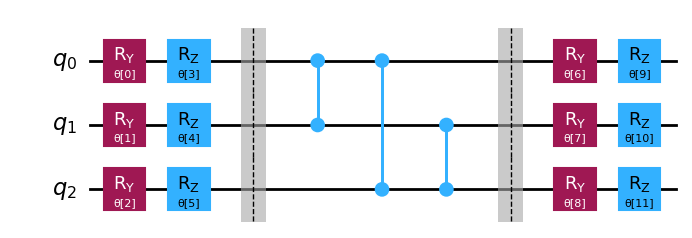

In [13]:
num_qubits = 3
rotation_blocks = ["ry", "rz"]
entanglement_blocks = 'cz'
entanglement = "full"

ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=rotation_blocks,
    entanglement_blocks=entanglement_blocks,
    entanglement=entanglement,
    reps=1,
    insert_barriers=True
)

### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [14]:
# Submit your answer using following code

grade_lab2_ex4(num_qubits, rotation_blocks, entanglement_blocks, entanglement) # Expected result type: int, List[str], str, str

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


前の図からわかるように、アンザッツ回路はパラメータベクトルθによって定義されており、その総数は以下の式で表されます：


<!-- From the previous figure we see that our ansatz circuit is defined by a vector of parameters θ, with the total number given by: -->

In [15]:
num_params = ansatz.num_parameters
num_params

12

<a id="exercise5"></a>
<a name="exercise5"></a>
<div class="alert alert-block alert-success">
    
### 演習 5: ISA回路へのトランスパイル
    
この例では、[FakeSherbrooke](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.fake_provider.FakeSherbrooke)を使用します。FakeSherbrookeは127量子ビットのシミュレーション用バックエンドで、トランスパイラーや他のバックエンド関連の機能をテストするのに役立ちます。

プリセットパスマネージャーは、`transpile()`関数で使用されるデフォルトのパスマネージャーです。`transpile()`は、量子回路を特定のバックエンドで実行するために最適化および変換する際に、`PassManager`オブジェクトを構築するための便利で簡単な方法を提供します。

**あなたのタスク:** パスマネージャーを定義してください。詳細については[Qiskitのドキュメント](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager)を参照してください。

</div>


<!-- <a id="exercise5"></a>
<a name="exercise5"></a>
<div class="alert alert-block alert-success">
    
### Exercise 5: Transpile to ISA circuits
    
In this example we will use the [FakeSherbrooke](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.fake_provider.FakeSherbrooke), a fake  (simulated) 127-qubit backend, useful for testing the transpiler and other backend-facing functionalities.

Preset pass managers are the default pass managers used by the `transpile()` function. `transpile()` provides a convenient and simple method to construct a standalone `PassManager` object that mirrors what the transpile function does when optimizing and transforming a quantum circuit for execution on a specific backend.

**Your Task:** Define the pass manager. Reference the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) for more info.


</div> -->

In [16]:
backend_answer = FakeSherbrooke()
optimization_level_answer = 3

pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)

isa_circuit = pm.run(ansatz)

<div class="alert alert-block alert-info">
    
<b>ヒント: 正しいバックエンドを使用していることを確認してください！</b>

採点ツールは**FakeSherbrooke**を想定して設計されているため、127量子ビットのマップを期待しています。別のバックエンドを使用すると、問題が発生する可能性があります。

</div>


<!-- <div class="alert alert-block alert-info">
    
<b>Tip: Make sure you are using the right backend! </b>

The grader was designed with **FakeSherbrooke** in mind, and therefore is expecting a 127 qubit map. If you use another backend you might encounter issues.

    
</div> -->

In [17]:
# Submit your answer using following code

grade_lab2_ex5(isa_circuit) # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


最新バージョンのQiskit Runtimeでは、バックエンドに送信されるすべての回路は、そのバックエンドのターゲットの制約を満たす必要があります。そのような回路は、そのバックエンドの命令セットアーキテクチャ（[ISA](https://www.ibm.com/quantum/blog/isa-circuits?social_post=sf187802680&sf187802680=1)）に準拠していると見なされます。つまり、デバイスが理解し実行できる命令のセットに基づいて記述されています。これらのターゲット制約は、デバイスのネイティブな基底ゲート、量子ビットの接続性、そして必要に応じてパルスやその他の命令のタイミング仕様などの要因によって定義されます。

ISA回路を視覚化するためには、次のコマンドを実行できます：


<!-- With the newest version of Qiskit Runtime, all circuits submitted to a backend must conform to the constraints of the backend’s Target. Such circuits are considered to be written in terms of that backend’s Instruction Set Architecture ([ISA](https://www.ibm.com/quantum/blog/isa-circuits?social_post=sf187802680&sf187802680=1)) — i.e., the set of instructions the device can understand and execute. These Target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and when relevant, its pulse and other instruction timing specifications.
To visualize our ISA circuits we can run: -->

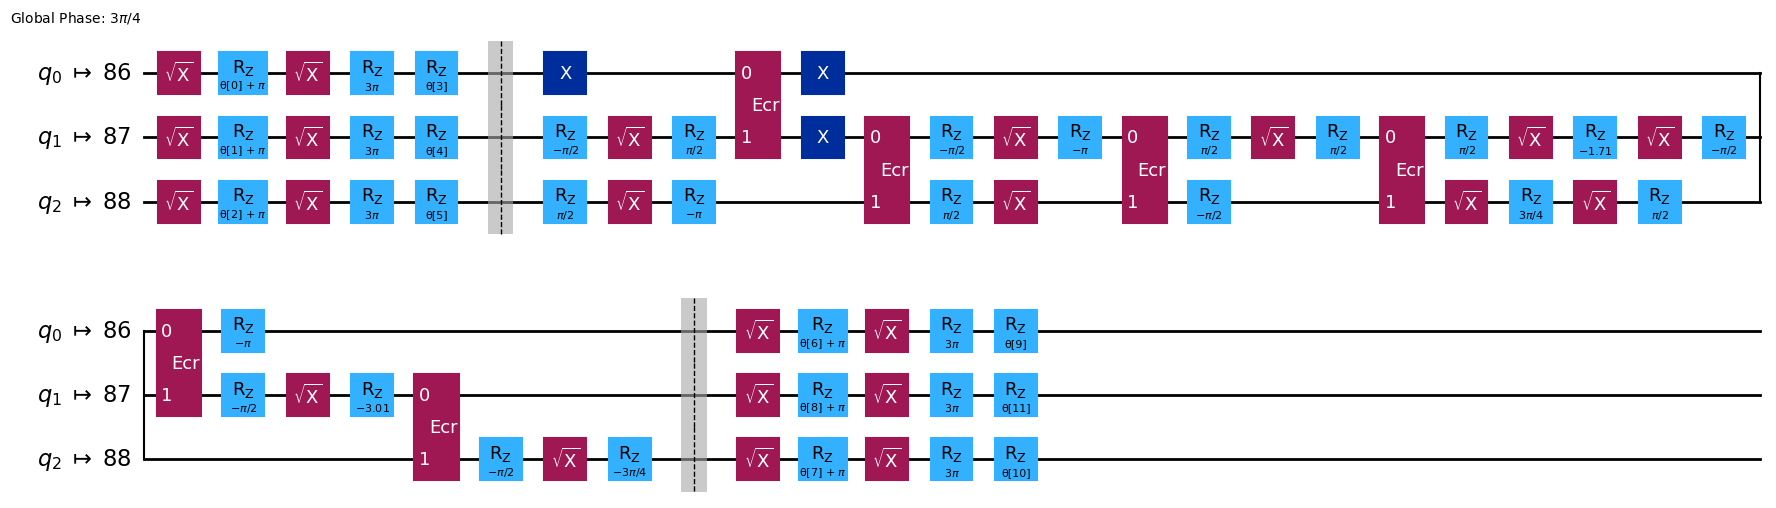

In [18]:
isa_circuit.draw('mpl', idle_wires=False,)

ご覧のとおり、トランスパイル後の回路には、バックエンドのネイティブな基底ゲートのみが含まれています。ISA回路に関する詳細は、IBMチームの以下のリソースを参照してください：

- [ISA回路とは？](https://www.ibm.com/quantum/blog/isa-circuits)
- [新しいISA回路要件の理解](https://docs.quantum.ibm.com/announcements/news/2024-05-06-ISA-circuit-requirement#understanding-the-new-isa-circuits-requirement)

次のセルを実行してハミルトニアンを定義し、演習6に進みましょう。


<!-- As you can see, after transpilation, the circuit only contain the native basis gates of the backend. For more details on ISA circuits check out these resources from the IBM team:

- [What are ISA circuits?](https://www.ibm.com/quantum/blog/isa-circuits)
- [Understanding the new ISA circuits requirement](https://docs.quantum.ibm.com/announcements/news/2024-05-06-ISA-circuit-requirement#understanding-the-new-isa-circuits-requirement)

You can run the next cell to define our Hamiltonian, then move on to Exercise 6. -->

In [19]:
# Define our Hamiltonian
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

<a id="exercise6"></a>
<a name="exercise6"></a>
<div class="alert alert-block alert-success">
    
### 演習 6: コスト関数の定義
    
多くの古典的な最適化問題と同様に、VQE問題の解はスカラーコスト関数の最小化として定式化できます。VQEのコスト関数はシンプルです：エネルギーです！

**あなたのタスク:** Qiskit Runtime Estimatorを使用して、与えられたパラメータ化された状態とハミルトニアンのエネルギーを見つけることで、コスト関数を定義してください。

</div>

VQEに関する詳細：
- https://learning.quantum.ibm.com/course/variational-algorithm-design
- https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver


<!-- <a id="exercise6"></a>
<a name="exercise6"></a>
<div class="alert alert-block alert-success">
    
### Exercise 6: Defining the cost function
    
Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. The cost function for our VQE is simple: the energy!

**Your Task:** Define a cost function by using Qiskit Runtime Estimator to find the energy for a given parameterized state and our Hamiltonian.

</div>

More about VQE:
- https://learning.quantum.ibm.com/course/variational-algorithm-design
- https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver -->

In [20]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)


### Don't change any code past this line ###
    # print(energy)
    return energy, result

In [21]:
# Submit your answer using following code

grade_lab2_ex6(cost_func) # Expected result type: Callable

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


コールバック関数は、VQEのような反復アルゴリズムの進行状況に関する追加情報をユーザーが取得するための標準的な方法です。しかし、それ以上のことも可能です。ここでは、ミュータブルオブジェクト（辞書）を使用して、アルゴリズムの各反復で得られるベクトルを保存します。これにより、失敗による再開が必要になった場合や、別の反復回数を返す必要がある場合に備えることができます。


<!-- Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm (such as VQE). However, it is possible to do much more than this. Here, we use a mutable object (dictionary), to store resulting vector at each iteration of our algorithm, in case we need to restart the routine due to failure or return the another iteration number. -->

In [22]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

古典オプティマイザーによる最適化

<!-- ### Using the Classical Optimizer -->

これで、任意の古典的な最適化手法を使用してコスト関数を最小化できるようになりました。  
実際の量子ハードウェアでは、最適化手法の選択が重要です。すべての最適化手法が、ノイズの多いコスト関数のランドスケープを同等に扱えるわけではありません。ここでは、SciPyのルーチンを使用します。

ルーチンを開始するために、ランダムな初期パラメータセットを指定します：


<!-- We can now use a classical optimizer of our choice to minimize the cost function.
In real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well. Here, we can use SciPy routines.

To begin the routine, we specify a random initial set of parameters: -->

In [23]:
np.random.seed(123)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([4.37604495, 1.79786647, 1.42534972, 3.46401286, 4.52055686,
       2.65845629, 6.1623232 , 4.30291215, 3.02178426, 2.46374703,
       2.15625107, 4.58075441])

<a id="exercise7"></a>
<a name="exercise7"></a>
<div class="alert alert-block alert-success">
    
### 演習 7: QiskitRuntimeService V2 Primitives、ローカルテストモード、セッション
    

次に、新しいQiskitRuntimeServiceの[V2 Primitives](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives)を使用します：[EstimatorV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2)と[SamplerV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2)です。

新しいEstimatorインターフェースでは、単一の回路とその回路に対する複数の観測量およびパラメータ値セットを指定できます。これにより、パラメータ値セットおよび観測量のスイープを効率的に指定できます。以前は、データのサイズを合わせるために同じ回路を複数回指定する必要がありました。また、最適化レベルとレジリエンスレベルを簡単な調整ノブとして使用することもできますが、V2 Primitivesでは、個別のエラー緩和/抑制メソッドをオンまたはオフにしてカスタマイズする柔軟性が提供されます。

SamplerV2は、量子回路の実行から量子レジスタをサンプリングするという主要なタスクに焦点を絞るように簡素化されています。サンプルを重みなしで返し、プログラムによって定義されるタイプで出力します。また、出力データはプログラムで定義された出力レジスタ名ごとに分離されます。この変更により、将来的に古典的な制御フローを持つ回路のサポートが可能になります。

さらに、Qiskitの1.0[ローカルテストモード](https://docs.quantum.ibm.com/verify/local-testing-mode)を使用します。ローカルテストモード（qiskit-ibm-runtime 0.22.0以降で利用可能）は、プログラムを微調整して実際の量子ハードウェアに送信する前に、開発およびテストを支援するために使用できます。

**あなたのタスク:** ローカルテストモードを使用してプログラムを検証し、その後バックエンド名を変更してIBM Quantumシステム上で実行してください。

</div>



<!-- <a id="exercise7"></a>
<a name="exercise7"></a>
<div class="alert alert-block alert-success">
    
### Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode, and Sessions
    

Next, we will use the new QiskitRuntimeService [V2 primitives](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives): [EstimatorV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) and [SamplerV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2).

The new Estimator interface lets you specify a single circuit and multiple observables and parameter value sets for that circuit, so that sweeps over parameter value sets and observables can be efficiently specified. Previously, you had to specify the same circuit multiple times to match the size of the data to be combined. Also, while you can still use optimization_level and resilience_level as the simple knobs, V2 primitives give you the flexibility to turn on or off individual error mitigation / suppression methods to customize them for your needs.

SamplerV2 is simplified to focus on its core task of sampling the quantum register from the execution of quantum circuits. It returns the samples, whose type is defined by the program, without weights. The output data is also separated by the output register names defined by the program. This change enables future support for circuits with classical control flow.

We will also use Qiskit's 1.0 [local testing mode](https://docs.quantum.ibm.com/verify/local-testing-mode). Local testing mode (available with qiskit-ibm-runtime 0.22.0 or later) can be used to help develop and test programs before fine-tuning them and sending them to real quantum hardware.

**Your Task:** Use local testing mode to verify your program, then change the backend name to run it on an IBM Quantum system.

</div> -->

In [24]:
### Select a Backend
## Use FakeSherbrooke to simulate with noise that matches closer to the real experiment. This will run slower.
## Use AerSimulator to simulate without noise to quickly iterate. This will run faster.

#backend = FakeSherbrooke()
backend = AerSimulator()

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

estimator = Estimator(backend)

res = minimize(
    cost_func_2,
    x0,
    args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
    method="COBYLA",
    options={'maxiter': 60})

In [25]:
assert res.fun < -2.7

<div class="alert alert-block alert-info">
    
<b>ヒント: 収束しない場合は`maxiter`を増やしてください </b>

コストが収束しない場合は、`maxiter`を増やしてください（100が適切な値です）。その後、演習7を再度実行してください。
    
</div>


<!-- <div class="alert alert-block alert-info">
    
<b>Tip: Increase `maxiter` if you do not see convergence </b>

If the cost is not converging, increase the `maxiter` (100 is an appropriate number) and run Ex 7 again.
    
</div> -->

結果を見てみましょう：

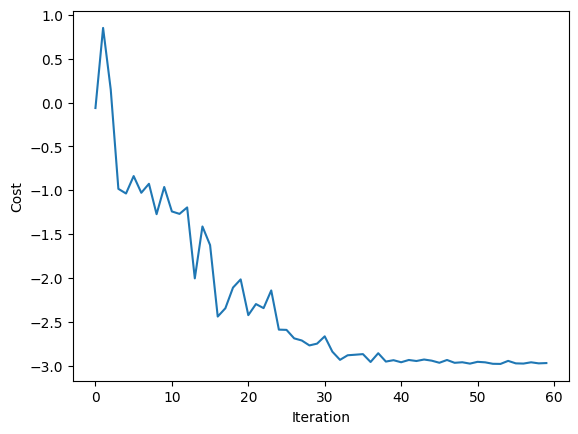

In [26]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()

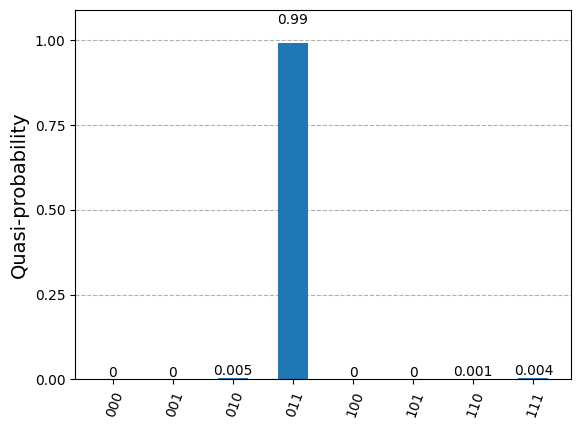

In [27]:
final_state = Statevector(ansatz.assign_parameters(callback_dict['prev_vector']))

plot_histogram({format(i, '03b'): np.abs(final_state.data[i])**2 for i in range(1<<3)})

🎉 予想通り、VQEアルゴリズムは反復を重ねるごとにエネルギーを最小化し、基底状態に到達しました。これで、新しいQiskit 1.0の機能を使用してVQEアルゴリズムを成功裏に実装することができました！

このノートブックを完了していただき、ありがとうございます。残りのノートブックも頑張ってください！


<!-- 🎉 As expected our VQE algorithm minimized our energy across iterations, until reaching the ground state. We have now successfully implemented a VQE algorithm using brand-new Qiskit 1.0 functionalities!

Thank you for completing this notebook, and good luck with the remaining ones! -->

# Additional information

**Created by:** James Weaver, Maria Gragera Garces

**Advised by:** Junye Huang

**Translated by:** Honomi Kashihara

**Version:** 1.3.0